# Introduction
This notebook illustrates a process of trial and error with various methods of stock prediction methods as a part of my bachelor's thesis. I am sure that most of you already know these methods - **LSTM**, **ARIMA** (and its variations) and **MCMC (Markov Chain Monte Carlo)**. The thing is that stock prices are usually a bit tougher to forecast due to market volatility and social influence on the trend of each stock. Thus, the key point in my research was finding the way to combine such methods in order to make my predictions flexible, depending on each stock's historical data. I hope you will find this notebook useful.

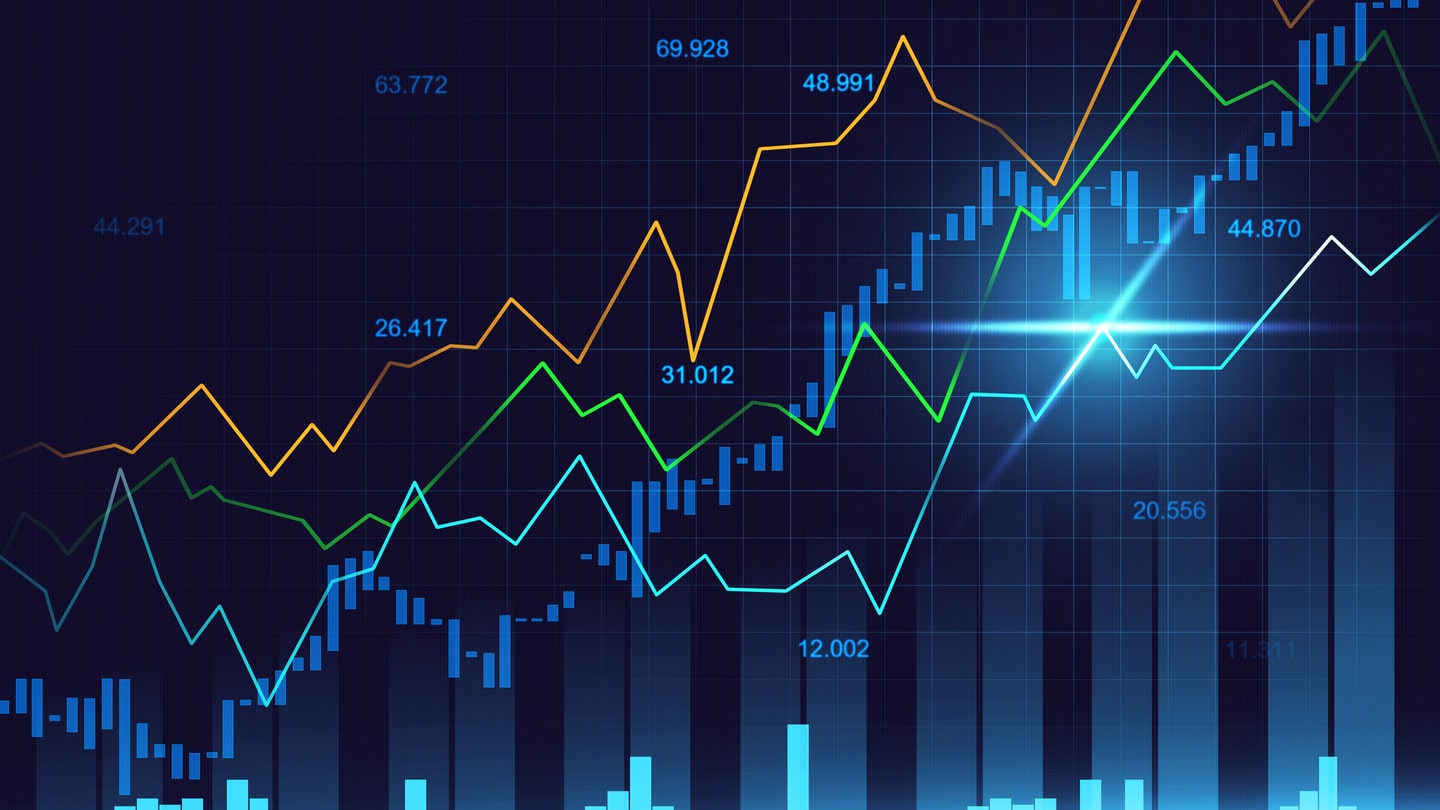
> The stock market refers to the collection of markets and exchanges where regular activities of buying, selling, and issuance of shares of publicly-held companies take place.
> A stock or share (also known as a company's "equity") is a financial instrument that represents ownership in a company or corporation and represents a proportionate claim on its assets (what it owns) and earnings (what it generates in profits).

Forecasting the direction of future stock prices is a widely studied topic in many fields including trading, finance, statistics and computer science. The motivation for which is naturally to predict the direction of future prices such that stocks can be bought and sold at profitable positions.

# Table of contents
1. [Installing necessary packages](#section-one)
1. [Collecting train data](#section-two)
1. [LSTM](#section-three)
1. [ARIMA](#section-four)
1. [Monte Carlo Markov Chain (Metropolis_Hastings method)](#section-five)
1. [Prediction optimization](#section-six)  
1. [Summary](#section-seven)    

<a id="section-one"></a>
# Installing necessary packages

For data scraping I use yfinance package, it is easy to install and use.

> *yfinance is a popular open source library developed by Ran Aroussi as a means to access the financial data available on Yahoo Finance. Yahoo Finance offers an excellent range of market data on stocks, bonds, currencies and cryptocurrencies. It also offers market news, reports and analysis and additionally options and fundamentals data- setting it apart from some of it’s competitors.*

Documentation is available at [Yfinance](https://pypi.org/project/yfinance/)

In [1]:
!pip install yfinance --quiet
!pip install pmdarima --quiet

*PuLP is a python library which can be used to solve linear programming problems.*

PuLP is usually used for simpler tasks, but it can also come handy for predictions blending. By default, CBC solver is used in the package, but there are plenty more of them available, for example, CPLEX, Gurobi and GLPK. For reference, you can see how PuLP is used for optimization tasks in my other notebook: [Optimization problem solving with PuLP](https://www.kaggle.com/equinxx/optimization-problem-solving-with-pulp)

[Documentation source](http://coin-or.github.io/pulp/)

In [2]:
!pip install statsmodels==0.11.0rc1 --quiet
!pip install -Iv pulp==1.6.8 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 1.8.2 requires statsmodels!=0.12.0,>=0.11, but you have statsmodels 0.11.0rc1 which is incompatible.
plotnine 0.8.0 requires statsmodels>=0.12.1, but you have statsmodels 0.11.0rc1 which is incompatible.
     |████████████████████████████████| 13.5 MB 862 kB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
  Created wheel for pulp: filename=PuLP-1.6.8-py3-none-any.whl size=12269612 sha256=33efa713c371706a030061b8a148b4e0c0275146eac5bd03b6bcd7df7b524757
  Stored in directory: /root/.cache/pip/wheels/ef/80/90/298f850e9f5e1f1a41725c8b632c8652f4085a81f2374683db
Successfully built pulp
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0

<a id="section-two"></a>
# Collecting train data

In [3]:
import yfinance as yf

# getting data from Yahoo Finance
stock_name = 'AMD'  # here you can change the name of stock ticker, for example we will take AMD ticker
data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")

[*********************100%***********************]  1 of 1 completed


In [4]:
# import plotly package for graphs
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

<a id="section-three"></a>
# LSTM model

Model structure:


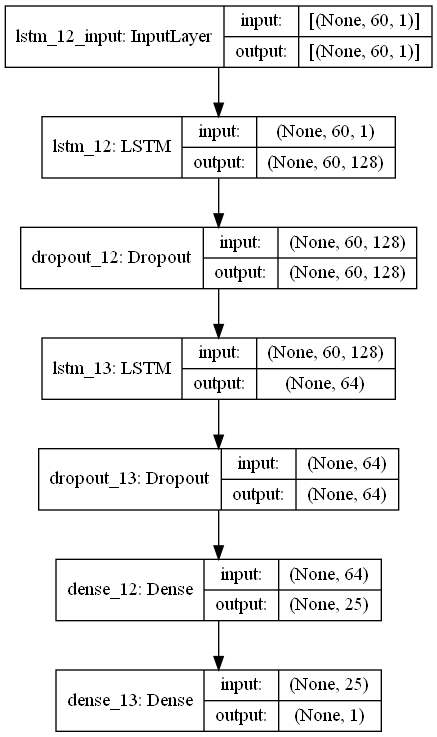

In [5]:
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

def lstm(stock_name, data):
    # Choose only Close price of stock
    data = data.filter(['Close'])
    dataset = data.values
    # Train data - 80%, test - 20%
    training_data_len = int(np.ceil( len(dataset) * .80 ))
    
    # Scale our data from 0 to 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Use our scaled data for training
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.35))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Тrain the model
    model.fit(x_train, y_train, batch_size=1, epochs=21)
    
    # Structure of the model
    keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

    # Create test dataset
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Predict on test data
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # For finding error we use RMSE formula, but MSE can be used too
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'RMSE LSTM: {rmse}')
    
    # Graphs
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #valid['Predictions'] = predictions
    train_gr = np.reshape(train, (203,))
    train_gr = train_gr['Close']
    valid_gr = np.reshape(valid, (50,))
    valid_gr = valid_gr['Close']
    preds_gr = np.reshape(predictions, (50,))
    

    x_train = list(range(0, len(train_data)))
    x_valid = list(range(len(train_data)-1, len(dataset)))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_train, y=train_gr, mode='lines+markers', marker=dict(size=4),  name='train'))
    fig.add_trace(go.Scatter(x=x_valid, y=valid_gr, mode='lines+markers', marker=dict(size=4), name='valid'))
    fig.add_trace(go.Scatter(x=x_valid, y=preds_gr, mode='lines+markers', marker=dict(size=4), name='predictions'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} LSTM data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    # Predict stock prices for next moth
    data_new = yf.download(stock_name, start="2021-03-01", end="2021-04-30")

    data_new = data_new.filter(['Close'])
    dataset = data_new.values
    training_data_len = len(dataset)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    test_data = scaled_data[training_data_len - len(data_new): , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(20, len(test_data)):
        x_test.append(test_data[i-20:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    hist_data_new = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data_new = hist_data_new.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data_new = hist_data_new['Close']
    hist_data_new = np.array(hist_data_new)
    pred_lstm = model.predict(x_test)
    pred_lstm = pred_lstm[:-1]
    pred_lstm = scaler.inverse_transform(pred_lstm)

    
    # build graphs
    preds_gr = np.reshape(pred_lstm, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data_new, mode='lines+markers',  name='historical'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} LSTM prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    return pred_lstm, rmse

In [6]:
lstm_pred, lstm_rmse = lstm(stock_name, data)

[array([0.08982803, 0.07299674, 0.09641421, 0.05287229, 0.01957555,
       0.03476036, 0.        , 0.09019393, 0.09092575, 0.11342848,
       0.10592757, 0.1527625 , 0.22575924, 0.22685696, 0.26271498,
       0.25631172, 0.26308088, 0.18898643, 0.24387117, 0.24350533,
       0.24862788, 0.25429933, 0.23637026, 0.20252469, 0.17929014,
       0.13336994, 0.18240032, 0.17563115, 0.17508232, 0.17124041,
       0.19392606, 0.24057815, 0.20435416, 0.17544823, 0.21807534,
       0.21240396, 0.21953897, 0.23563851, 0.2524698 , 0.22063669,
       0.23014998, 0.19392606, 0.18569341, 0.16739849, 0.20508597,
       0.20197587, 0.20032932, 0.18551042, 0.18368095, 0.19227952,
       0.18990123, 0.2524698 , 0.27167945, 0.18733995, 0.19959751,
       0.22118551, 0.21716061, 0.21880716, 0.20947678, 0.21295279])]
[0.22264907067176842]

[array([0.08982803, 0.07299674, 0.09641421, 0.05287229, 0.01957555,
       0.03476036, 0.        , 0.09019393, 0.09092575, 0.11342848,
       0.10592757, 0.1527625 , 0.22

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
# Check size of predictions array
print(lstm_pred.shape)

(22, 1)


<a id="section-four"></a>
# ARIMA

*Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.*

*ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.*

Let's perform ADF test for stock data:

In [8]:
data_adf = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
data_adf = data_adf['Close']

from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_adf)

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



(0.8518357995056978, True)

Therefore we can see that data is stationary and we can use regressive models for forecasting. Now we can apply ARIMA (Auto ARIMA)

In [9]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ADFTest
from pmdarima.datasets import load_wineind
import random

def arima(stock_name, data):
    df_close = data['Close']
    
    # Split data into train and test set (90% - train, 10% - test)
    df_log = df_close
    #train_data, test_data = df_log[3:int(len(df_log) * 0.9)], df_log[int(len(df_log) * 0.9):]
    train_data, test_data = df_log[3:int(len(df_log) * 0.9)], df_log[int(len(df_log) * 0.9):]
    test_values = len(df_log) * 0.01 + 1.0
    x_train = list(range(0, 224))
    x_test = list(range(224, int(len(data))))
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_train, y=train_data, mode='lines+markers', marker=dict(size=4),  name='train'))
    fig.add_trace(go.Scatter(x=x_test, y=test_data, mode='lines+markers', marker=dict(size=4), name='test'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} ARIMA data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    model =  pm.auto_arima(df_log,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

    model.summary()

    exo_data = data['Volume']
    exo_data = exo_data[int(len(exo_data) * 0.9):]
    
    preds = model.predict(n_periods = 22, X = exo_data)

    preds = np.vstack(preds)
    hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data = hist_data['Close']
    hist_data = np.array(hist_data)
    
    rmse = np.sqrt(np.mean(((preds - hist_data) ** 2)))
    print(f'RMSE ARIMA: {rmse}')
    
    # build graphs
    preds_gr = np.reshape(preds, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} ARIMA prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

    return preds, rmse

In [10]:
arima_pred, arima_rmse = arima(stock_name, data)
print(arima_pred.shape)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1554.747, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1212.598, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1400.799, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1559.251, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1262.089, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1192.848, Time=0.42 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=1184.962, Time=0.98 sec
 ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=1178.594, Time=1.61 sec
 ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=1172.640, Time=3.87 sec
 ARIMA(1,0,0)(5,1,1)[7] intercept   : AIC=inf, Time=10.68 sec
 ARIMA(1,0,0)(4,1,1)[7] intercept   : AIC=inf, Time=4.43 sec
 ARIMA(0,0,0)(5,1,0)[7] intercept   : AIC=1552.934, Time=2.55 sec
 ARIMA(2,0,0)(5,1,0)[7] intercept   : AIC=1172.822, Time=4.49 sec
 ARIMA(1,0,1)(5,1,0)[7] intercept   : AIC=1173.046, Time=4.68 sec
 ARIMA(0,0,1)(5,1,0)[7] intercept   : AIC=

(22, 1)


Since we can see a big difference between real and predicted data, we might want to try other regressive methods, like SARIMAX or VAR. Actually, I tested them but they showed almost the same results (see below). The reason might be a high market volatility during prediction period where such methods are not able to adapt their forecasting trend for each day. BTW if we test these regressive methods on older data, we will see that an error is lower.

**SARIMAX**

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
data3 = data['Close']
    
# Split data into train and test set (90% - train, 10% - test)
train3_data, test3_data = data3[3:int(len(data3) * 0.9)], data3[int(len(data3) * 0.9):]
#test_values = len(data3) * 0.01 + 1.0
x_train = list(range(0, 224))
x_test = list(range(224, int(len(data3))))

exo_data = data['Volume']
exo_data = exo_data[int(len(exo_data) * 0.9):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train, y=train3_data, mode='lines+markers', marker=dict(size=4),  name='train'))
fig.add_trace(go.Scatter(x=x_test, y=test3_data, mode='lines+markers', marker=dict(size=4), name='test'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} SARIMAX data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()
    
model = SARIMAX(train3_data, order=(3, 1, 2))

arima_model = model.fit(X = exo_data, disp=-1)

print(arima_model.summary())


preds3 = arima_model.predict(n_periods=22, alpha=0.05)

preds3 = np.vstack(preds3)
preds3 = preds3[-22:]
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)
    
rmse = np.sqrt(np.mean(((preds3 - hist_data) ** 2)))
print(f'RMSE SARIMAX: {rmse}')
    
preds_gr = np.reshape(preds3, (22,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers', name='historical'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} SARIMAX prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -500.750
Date:                Thu, 02 Sep 2021   AIC                           1013.500
Time:                        23:16:24   BIC                           1033.943
Sample:                             0   HQIC                          1021.753
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2628      0.111    -11.371      0.000      -1.480      -1.045
ar.L2         -1.0686      0.129     -8.281      0.000      -1.322      -0.816
ar.L3         -0.1083      0.072     -1.506      0.1

**VAR**

In [12]:
import math
data4 = yf.download(stock_name, start="2020-03-26", end="2021-03-29")
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
data4 = data4.drop(['Adj Close'], axis=1)

# Train set - 80%
train4 = data4[:int(0.8*(len(data)))]
valid4 = data4[int(0.8*(len(data))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model4 = VAR(endog=train4)
model4_fit = model4.fit(trend = 'ctt')

# make prediction on validation
prediction = model4_fit.forecast(model4_fit.y, steps=len(valid4))
pred4 = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,5):
    for i in range(0, len(prediction)):
        pred4.iloc[i][j] = prediction[i][j]

# Check rmse
i = 'Close'
print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred4[i], valid4[i])))


model4 = VAR(endog=data4)
model4_fit = model4.fit(trend = 'ct')
yhat = model4_fit.forecast(model4_fit.y, steps=23)
preds = []

i = 0
while i < (len(yhat)):
    pr = yhat[i][3]
    preds.append([pr])
    i = i + 1
#print(preds)
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)

preds_gr = np.reshape(preds, (23,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} VAR prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()


[*********************100%***********************]  1 of 1 completed
rmse value for Close is :  15.22681268996577
[*********************100%***********************]  1 of 1 completed


<a id="section-five"></a>
# Monte Carlo Markov Chain (Metropolings-Hastings method)

> *MCMC allows us to draw samples from any distribution that we can't sample from directly. It can be used to sample from the posterior distribution over parameters. It has seen much success in many applications, such as computing the distribution of parameters, given a set of observations and some prior belief, and also computing high dimensional integrals in physics and in digital communications.*

When applying the Monte Carlo method, there is a problem of obtaining a sample from some multidimensional probability distribution *p(x)*. The solution to this problem is the basis of MKML methods. In particular, there have been attempts to integrate very complex functions with random simulations. The result of these attempts is the Metropolis-Hastings algorithm. 
This algorithm requires the use of a simple distribution, called the proposal distribution *Q(θ'/θ)*, to extract suitable values from the posterior distribution *P(Θ=θ/D)*. 
Metropolis-Hastings method uses *Q* to randomly walk in the distribution space, accepting or rejecting jumps to new positions based on how likely the sample is. This "memoriless" random walk is the "Markov Chain" part of MCMC.

The probability of each new sample is determined by the function *f*. The function *f* must be proportional to the given distribution from which we want to take samples. The function f is usually chosen as a probability density function that expresses this proportionality. To get a new position of the parameter, just take our current one *θ* and propose a new one *θ'*, that is randomly drawn from our distibution *Q(θ'/θ)*. Usually it is a symmetric distribution, for example, a normal distribution with mean *θ* and some standard deviation *σ: Q(θ'/θ) = N(θ,σ)*. The acception criterion for the sample θ' is the formula:

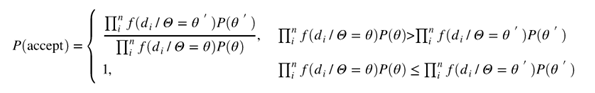

If *θ'* is more likely than the current *θ*, then we always accept *θ'*. If it is less likely than the current *θ*, then we might accept it or reject it randomly with decreasing probability, the less likely it is.

References: 
[Reference 1](https://github.com/Joseph94m/MCMC/blob/master/MCMC.ipynb)
[Reference 2](http://janroman.dhis.org/stud/I2010/MCBS/AFI.pdf)

For stock predicting using the following method we use stock price formula below, according to Black-Scholes method. That means, that price of stock follows a geometric Brownian motion with constant drift and volatility.

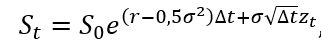

z_t is our random shift indicator, which is generated with MCMC method.
The inputs for the Black-Scholes equation are volatility (in our case 25%), stock price for previous time period and the risk-free interest rate (10%). As we predict prices for each day of next trading month, we use ∆t as 1(day)/22(trading days in month).


In [13]:
import numpy as np
import math
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import pandas as pd
import yfinance as yf
import statistics as stat
from scipy.special import ndtri
from scipy.stats import norm
import random
from sklearn.metrics import mean_squared_error

mu, sig, N = 1.1, 1, 100000
pts = []


def q(x):
    return (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2)))

def MCMC(n):
    r = np.zeros(1)
    p = q(r[0])
    pts = []

    for i in range(N):
        rn = r + np.random.uniform(-1, 1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn / p:
                p = pn
                r = rn
        pts.append(r)

    pts = random.sample(pts, len(pts))
    pts = np.array(pts)
    
    return pts

def MH(stock_name, data):
    hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data = hist_data['Close']
    hist_data = np.array(hist_data)
    stock_pred = []
    data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    dt1 = data['Close']
    maturnity = 1
    volatility = 0.25
    risk_free = 0.1
    timestep = 1
    steps = 22
    delta_t = maturnity / steps
    i = 0
    stock_pred.append(dt1[-1])
    while timestep < steps:
        stock_price = stock_pred[-i]
        time_exp = maturnity - delta_t * timestep
        # Generate z_t using MCMC method
        pts = MCMC(N)
        stock_price = stock_price * math.exp(((risk_free - 0.5 * (
            math.pow(volatility, 2))) * delta_t + volatility * math.sqrt(delta_t) * pts[timestep + 5]))
        stock_pred.append(stock_price)
        i = i + 1
        timestep = timestep + 1
    
    rmse = math.sqrt(mean_squared_error(hist_data, stock_pred))
    print(f'RMSE MCMC: {rmse}')
    
    
    # build graphs
    preds_gr = np.reshape(stock_pred, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} MCMC prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    return stock_pred, rmse

In [14]:
mcmc_pred, mcmc_rmse = MH(stock_name, data)
mcmc_pred = np.vstack(mcmc_pred)

[*********************100%***********************]  1 of 1 completed
RMSE MCMC: 6.098095537499262


In [15]:
print(mcmc_pred.shape)

(22, 1)


<a id="section-six"></a>
# Prediction optimization

Now let's compare performance of 3 methods: LSTM, ARIMA and MCMC.

In [16]:
# compare predictions
lstm_pred_gr = np.reshape(lstm_pred, (22,))
mcmc_pred_gr = np.reshape(mcmc_pred, (22,))
arima_pred_gr = np.reshape(arima_pred, (22,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers', line=dict(color='crimson', width=5),
                         marker=dict(color='crimson', size=10),  name='historical'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=lstm_pred_gr, mode='lines+markers', 
                         line=dict(color='goldenrod'), name='LSTM'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=mcmc_pred_gr, mode='lines+markers', 
                         line=dict(color='lightseagreen'), name='MCMC'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=arima_pred_gr, mode='lines+markers', 
                         line=dict(color='deepskyblue'), name='ARIMA'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text = f'{stock_name} predictions', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

x = ['LSTM', 'ARIMA', 'MCMC']
y = [lstm_rmse, arima_rmse, mcmc_rmse]

fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['LSTM RMSE (21 epochs)', 'ARIMA RMSE', 'MCMC RMSE (100000 iterations)'])])
fig.update_traces(marker_color='lightpink', marker_line_color='lightsalmon',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Prediction RMSE by methods')
fig.show()

Obviously, all threee methods demonstrate very different performance. What I do in the next step is just blending predictions of 3 models by creating an optimization problem, where target function is RMSE between forecast and historical data for last month: 
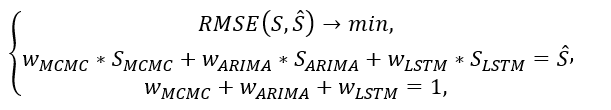

where *S* is the actual data for the prediction period;
*S^* - predicted data for the period;
*W* - weights for the forecasts of each model; 
The output is weighted prediction data which are close to the actual data. The model shown above is solved with PuLP package:

In [17]:
import pulp as plp

hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)

preds = []
mse = []

weights_lstm = 0.3
weight_mcmc = 0.4
weight_arima = 0.4

# weights solver
model = plp.LpProblem('Optimal_weights', plp.LpMinimize)
# weights--->variables
weight_lstm = plp.LpVariable("weight_lstm", lowBound = 0, upBound=0.6)
weight_mcmc = plp.LpVariable("weight_mcmc", lowBound = 0, upBound=0.6)
weight_arima = plp.LpVariable("weight_arima", lowBound = 0, upBound=0.6)

for i in range(len(hist_data)):
    preds.append(lstm_pred[i]*weight_lstm + mcmc_pred[i]*weight_mcmc + arima_pred[i]*weight_arima)
    
for i in range (len(hist_data)):
    mse.append(hist_data[i] - preds[i])
# target function--->mean squared error
mse = np.mean(mse)
sum_w = weight_lstm + weight_mcmc + weight_arima 

model += mse
model += sum_w <= 1.0
model += sum_w >= 1.0

plp.LpSolverDefault.msg = 1

# solve #
model.solve()
print('model solve')
status = model.solve()
print("Model status: ", plp.LpStatus[status])
print(model)

weight_mcmc_f = weight_mcmc.varValue
weight_arima_f = weight_arima.varValue
weight_lstm_f = weight_lstm.varValue

preds_final = []
# Create final predictions from 3 methods
for i in range(len(hist_data)):
    preds_final.append(lstm_pred[i]*weight_lstm_f + mcmc_pred[i]*weight_mcmc_f + arima_pred[i]*weight_arima_f)
preds_final = np.vstack(preds_final)    
#print(preds_final)

# build graphs
preds_gr = np.reshape(preds_final, (22,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions'))
fig.update_layout(legend_orientation="h",
                legend=dict(x=.5, xanchor="center"),
                title_text = f'{stock_name} final prediction', title_x = 0.5,
                xaxis_title="Timestep",
                yaxis_title="Stock price",
                margin=dict(l=0, r=0, t=30, b=0))
fig.show()

mse = []
for i in range (len(hist_data)):
    mse.append(abs(hist_data[i] - preds_final[i]))
mse = np.mean(mse)
rmse = math.sqrt(mse)
print(f'RMSE = {rmse}')
print(f'LSTM weight: {weight_lstm_f}')
print(f'MCMC weight: {weight_mcmc_f}')
print(f'ARIMA weight: {weight_arima_f}')

[*********************100%***********************]  1 of 1 completed
model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-76.95805400478609*weight_arima + -80.67923493818803*weight_lstm + -85.16952073220125*weight_mcmc + 81.69454609264027
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
weight_arima <= 0.6 Continuous
weight_lstm <= 0.6 Continuous
weight_mcmc <= 0.6 Continuous



RMSE = 1.852818656170059
LSTM weight: 0.4
MCMC weight: 0.6
ARIMA weight: 0.0


Calculated weights speak for themselves. Sadly, ARIMA did not prove to be efficient at all.

<a id="section-seven"></a>
# Summary

In this notebook various methods of stock price predicting were tested on historical stock data. Each method has its own advantages and disavantages, but those can be used for good by blending different methods for generating one prediction. In this case our historical data from last year shows high volatility, so methods like ARIMA lose their efficiency in forecasting. Using our blending method our predictions can be flexible, depending on previous historical data of the stock. 

***If you made it this far, congrats! Thank you for reading this and hope you enjoyed my notebook! Please feel free to comment and upvote :)***